In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


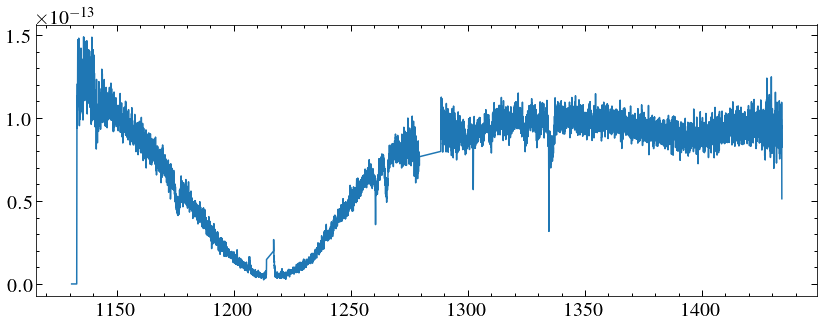

In [6]:
#hst spectrum

def boxcar(flux,factor):
    smoothed_flux=convolve(flux,Box1DKernel(factor))
    return smoothed_flux

w, f, e, dq = np.loadtxt('hst_data/spectra/ll_eri_COS_FUV_1291_2011-10-12.dat', unpack=True)
w, f, e, = w[dq==0], f[dq==0], e[dq==0]
mask = (w < 1214)|(w > 1217) & (f>0)            
w, f, e = w[mask], f[mask], e[mask]
f = boxcar(f, 5)
plt.plot(w,f)

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


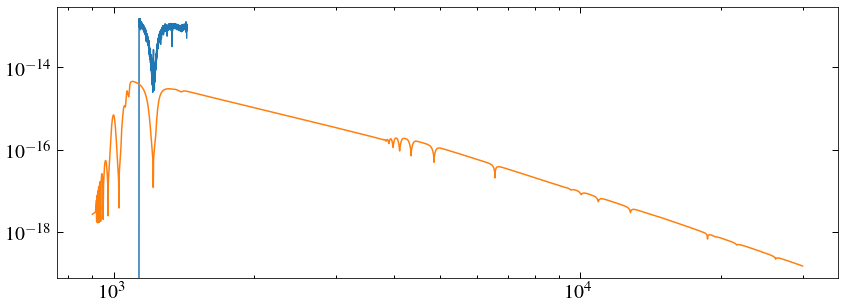

In [8]:
#distance = 62. #pc

#update with gaia distance 25/4/2018

distance = 56.6

mw, mf = np.loadtxt('lleri_wd.dat', unpack=True)
mf *= (10./distance)**2.

plt.plot(w,f)
plt.plot(mw, mf)
plt.xscale('log')
plt.yscale('log')

Well that didn't work. Before I scaled with GALEX and/or IUE. Let's see if there is GALEX data, although scaling to the COS spectrum should be ok. Not sure what that says about my U band calculations though. NB if it fails then wait for Gaia.

In [9]:
gw, gfj, ge=np.array([1530.,2310.]), np.array([5.54e-3,4.66e-3]), np.array([0.04e-3,0.03e-3])
c=2.998e8
gf=2.99792458e-5*gfj/(gw**2.)
ge=(ge/gfj)*gf
print(gf)

[7.09492169e-14 2.61807847e-14]


/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


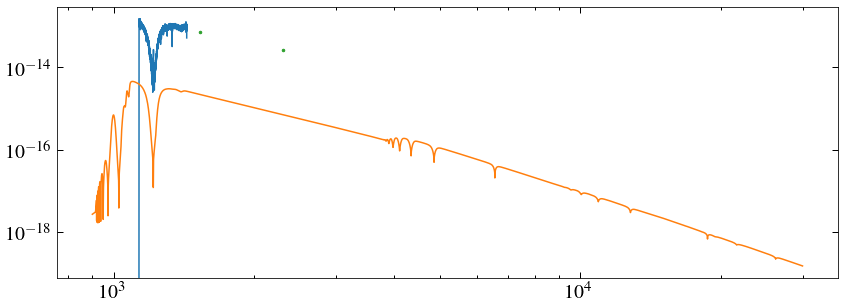

In [10]:
plt.plot(w,f)
plt.plot(mw, mf)
plt.errorbar(gw,gf,yerr=ge, marker='.', ms=5, ls='none')
plt.xscale('log')
plt.yscale('log')


Ok looks like it should be fine to scale to the GALEX flux.

In [11]:
gal =[]
for i in range(2):
    f_slice = (mw > gw[i]-10.) & (mw < gw[i]+10.)
    gal.append(np.median(mf[f_slice])/gf[i])
mf /= np.mean(gal)

(1000, 2500)

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


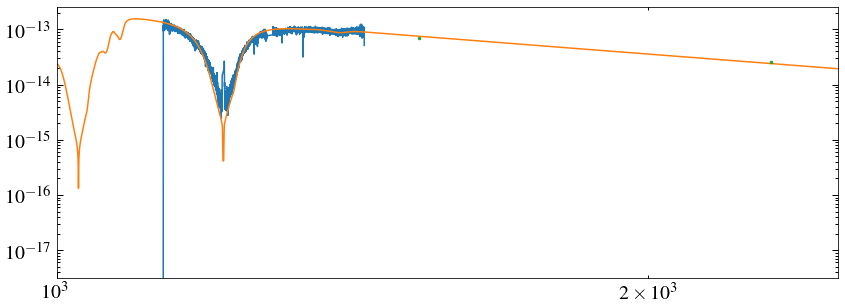

In [12]:
plt.plot(w,f)
plt.plot(mw, mf)
plt.errorbar(gw,gf,yerr=ge, marker='.', ms=5, ls='none')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1000,2500)

Much better. Now to calculate the mdwarf U band flux using http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

In [13]:
Mv =10.7
b_v = 1.552 #b-v
v_u = 1.175 #v-u
mv = Mv + (5.*np.log10(distance/10.))
U = mv + v_u + b_v
print(U)

17.19108215594136


Should be fine. The next stage is to work out the peak blackbody flare flux. For a M2.5, STScI says $\Delta$U = -8. (It's borderline as the line is between M2 and M3, so go with conservative case.

In [14]:
delta_u = -8
flare_u = U + delta_u
print(flare_u)

9.19108215594136


To the ETC! Check where the peak flux is first.

3225.0


/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


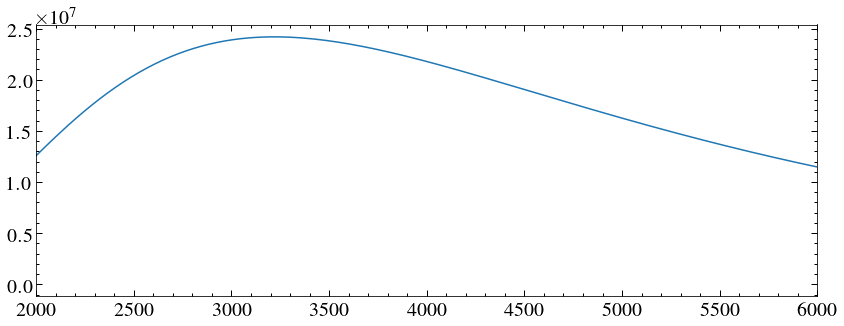

In [18]:
from astropy.modeling.blackbody import blackbody_lambda
f_bb=blackbody_lambda(mw, 9000)
plt.plot(mw, f_bb)
plt.xlim(2000,6000)
print(mw[np.argmax(f_bb)])

http://etc.stsci.edu/etc/plot_page/COS.sp.1152069/ gives a peak flux of $7.6\times10^{-13}$ Jangstroms. $1.85\times10^{-12}$ after Gaia. 


1.85e-12


/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


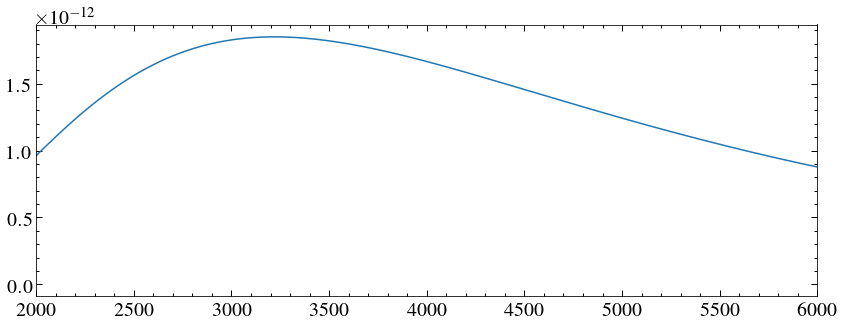

In [19]:
#peak_f = 7.6e-13
peak_f = 1.85e-12
f_bb = (f_bb*peak_f)/np.max(f_bb)
plt.plot(mw, f_bb)
plt.xlim(2000,6000)
print(np.max(f_bb))

Good, now to combine the models and put them into the ETC, with flares. 

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


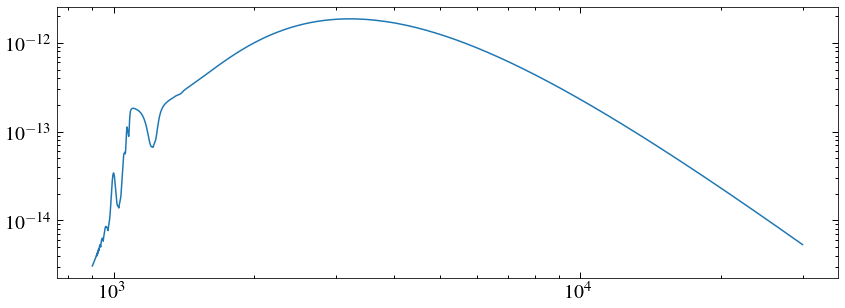

In [20]:
f_comb = mf + f_bb
plt.plot(mw, f_comb)
#plt.xlim(10,5000)
plt.xscale('log')
plt.yscale('log')

In [21]:
fl=open('ll_eri_flare.dat', 'w')
for a, b in zip(mw, f_comb):
        fl.write('%f %g \n' % (a,b))

And it's all ETC from here on in!